# Recipe
## Pick Time with Courier

In [1]:
import analitico
import analitico.plugin
import s24.plugin

from analitico.pandas import *

import missingno as msno
%matplotlib inline

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# pass api token to create factory
factory = analitico.authorize("tok_demo1_croJ7gVp4cW9")

def sample(df):
    return df.sample(n=4)

import datetime
print(datetime.datetime.now())

2019-03-23 19:15:26.449286


In [2]:
%config Application.log_level='DEBUG'
%config Application.log_level='INFO'
import logging
logging.getLogger().setLevel(logging.INFO)
log = logging.getLogger()
log.debug('Test debug')
log.info('Test info')

In [27]:
action = "train"

y_label = "pick_time.min"

# data used for sample prediction
data = [{
        "order_fulfillment_type": 1,
        "order_deliver_at_start": "2018-08-27 19:00:00",
        "courier_id": 109135.0,
        "odt_items_total": 12,
        "odt_items_with_variable_weight": 0,
        "store_name": "esselunga",
        "store_area": "MI6",
        "store_province": "MI",
        "store_ref_id": 5042,
        "courier_area": "MI13",
        "courier_orders_taken": 249,
        "courier_experience_days": 306.2845833333,
        "pick_time.min": 10.2 # just for testing, real data would not have y_true of course
    },
    {
        "order_fulfillment_type": 1,
        "order_deliver_at_start": "2018-09-28 20:00:00",
        "courier_id": 112147.0,
        "odt_items_total": 16,
        "odt_items_with_variable_weight": 1,
        "store_name": "ipercoop",
        "store_area": "MI4",
        "store_province": "MI",
        "store_ref_id": 4494,
        "courier_area": "MI4",
        "courier_orders_taken": 3387,
        "courier_experience_days": 316.7805439815,
        "pick_time.min": 38.9 # just for testing, real data would not have y_true of course
    }]



## Load training data

In [4]:
orders = factory.run_plugin(action=action, settings = {
    "name": "analitico.plugin.DatasetSourcePlugin",
    "dataset_id": "ds_s24_order_times_dyn"
})
sample(orders)

,order_id,order_amount,order_volume,order_deliver_at_start,order_deliver_at_end,order_paid_at,order_delivered_at,order_fulfillment_type,store_id,courier_id,picker_id,customer_id,odt_items_total,odt_items_with_variable_weight,odt_first_touched_at,odt_last_touched_at,store_name,store_area,store_province,store_lat,store_lng,store_ref_id,customer_province,customer_lat,customer_lng,customer_area,customer_ztl,customer_ref_id,customer_created_at,courier_soldo_enabled,courier_area,courier_orders_taken,courier_orders_sent,courier_created_at,courier_created_days,pick_time.min,pay_time.min,deliver_time.min
386963,913544,40.34,26.60,2018-12-22 11:00:00,2018-12-22 12:00:00,2018-12-22 11:06:07,2018-12-22 11:13:43,1,895648,88264.0,NaN,895684,4,0,2018-12-22 10:34:53,2018-12-22 10:42:15,carrefour market,RM3,RM,41.908997,12.447110,319,RM,41.901533,12.440255,RM3,0,580726,2018-12-21 12:59:22,1,RM3,3327,9438,2017-05-10 23:34:30,590.480289,7.366667,23.866667,7.600000
318130,760723,119.81,132.49,2018-09-29 09:00:00,2018-09-29 10:00:00,2018-09-29 09:44:40,2018-09-29 10:05:11,1,742247,102426.0,NaN,742283,24,2,2018-09-29 09:01:10,2018-09-29 09:35:51,iperlando,TV1,TV,45.690002,12.198842,266,TV,45.674211,12.249150,TV1,0,1127591,2018-09-28 13:53:06,1,TV1,666,1774,2017-09-11 17:57:31,382.657743,34.683333,8.816667,20.516667
379397,896849,49.57,30.38,2018-12-13 17:00:00,2018-12-13 18:00:00,2018-12-13 16:20:47,2018-12-13 16:27:35,1,878889,139021.0,NaN,878925,20,1,2018-12-13 15:52:12,2018-12-13 16:11:25,famila superstore,VA2,VA,45.673322,8.703691,1567,VA,45.678620,8.705080,VA2,0,418020,2018-12-12 22:06:19,0,VA2,518,1295,2018-07-10 15:39:47,156.028472,19.216667,9.366667,6.800000
334991,798151,33.26,61.63,2018-10-23 18:00:00,2018-10-23 19:00:00,2018-10-23 18:42:05,2018-10-23 20:04:19,1,779791,132377.0,NaN,779827,8,0,2018-10-23 17:54:51,2018-10-23 18:02:20,ipercoop,MI7,MI,45.496469,9.113667,4496,MI,45.467315,9.148416,MI7,0,314202,2018-10-21 08:58:40,1,MI7,1544,2711,2018-04-27 14:58:25,179.155324,7.483333,39.750000,82.233333


In [5]:
plugin = s24.plugin.AugmentCouriersPlugin(factory=factory)
orders = plugin.run(orders, action=action)

# Drop all the columns that will not be needed for this model
orders.drop(
    [
        "order_id", "order_deliver_at_end", "order_paid_at", "order_delivered_at", "order_amount", "order_volume",
        "customer_id", "customer_ref_id", "customer_province", "customer_lat", "customer_lng", "customer_area", "customer_ztl", "customer_created_at",
        "store_id", "store_lat", "store_lng",
        "picker_id",
        "courier_created_at", "courier_soldo_enabled", "courier_orders_sent",
        "odt_first_touched_at", "odt_last_touched_at",
        "pay_time.min", "deliver_time.min"
    ],
    axis = 1,
    inplace = True
)

In [6]:
print("Total orders: %d" % len(orders))
# orders completed in less than 2 minutes are bogus and should be removed
orders = orders[orders["pick_time.min"].notnull()]
orders = orders.loc[orders["pick_time.min"] > 2]
orders = orders.loc[orders["pick_time.min"] < 120]
print("Orders between 2 and 120 minutes: %d" % len(orders))

Total orders: 416807
Orders between 2 and 120 minutes: 214450


In [7]:
# check for missing data
#msno.matrix(orders)
pd_print_nulls(orders)

In [8]:
# distribution of values BEFORE filtering outliers
columns = ["pick_time.min", "odt_items_total", "odt_items_with_variable_weight", "courier_orders_taken", "courier_experience_days"]
orders[columns].describe()

,pick_time.min,odt_items_total,odt_items_with_variable_weight,courier_orders_taken,courier_experience_days
count,214450.000000,214450.000000,214450.000000,214450.000000,214450.000000
mean,24.721668,23.065414,3.464458,1563.000718,349.877473
std,18.220645,14.768712,3.693229,1428.689215,308.708165
min,2.000000,2.000000,0.000000,1.000000,0.000000
25%,11.783333,12.000000,1.000000,410.000000,108.000000
50%,20.150000,20.000000,2.000000,1111.000000,264.000000
75%,32.500000,30.000000,5.000000,2325.000000,478.000000
max,119.950000,251.000000,40.000000,7022.000000,1503.000000


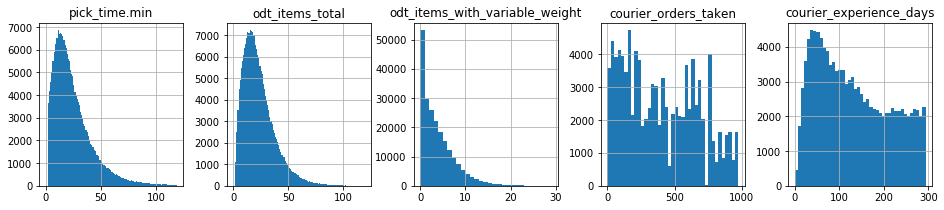

In [9]:
def chart_distributions():
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    hist = orders[["pick_time.min"]].hist(bins=range(0,120,1), ax=axes[0])
    hist = orders[["odt_items_total"]].hist(bins=range(0,120,1), ax=axes[1])
    hist = orders[["odt_items_with_variable_weight"]].hist(bins=range(0,30,1), ax=axes[2])
    hist = orders[["courier_orders_taken"]].hist(bins=range(0,1000,25), ax=axes[3])
    hist = orders[["courier_experience_days"]].hist(bins=range(0,300,7), ax=axes[4])
chart_distributions()

In [10]:
def pd_remove_outliers(df, column, zscore):
    df1 = df[[column]]
    return df[(np.abs(stats.zscore(df1)) <= zscore).all(axis=1)]

# keep features within n standard deviations
orders = pd_remove_outliers(orders, "pick_time.min", 3)
orders = pd_remove_outliers(orders, "odt_items_total", 3)
print("Filtered orders: %d" % len(orders))

Filtered orders: 207593


In [11]:
# distribution of values AFTER filtering outliers
columns = ["pick_time.min", "odt_items_total", "odt_items_with_variable_weight", "courier_orders_taken", "courier_experience_days"]
orders[columns].describe()

,pick_time.min,odt_items_total,odt_items_with_variable_weight,courier_orders_taken,courier_experience_days
count,207593.000000,207593.000000,207593.000000,207593.000000,207593.000000
mean,23.077215,21.933360,3.329462,1558.868695,349.607087
std,15.314920,12.762007,3.521978,1424.355548,308.606125
min,2.000000,2.000000,0.000000,1.000000,0.000000
25%,11.550000,12.000000,0.000000,410.000000,108.000000
50%,19.583333,20.000000,2.000000,1111.000000,264.000000
75%,31.050000,29.000000,5.000000,2325.000000,477.000000
max,79.383333,65.000000,37.000000,7022.000000,1503.000000


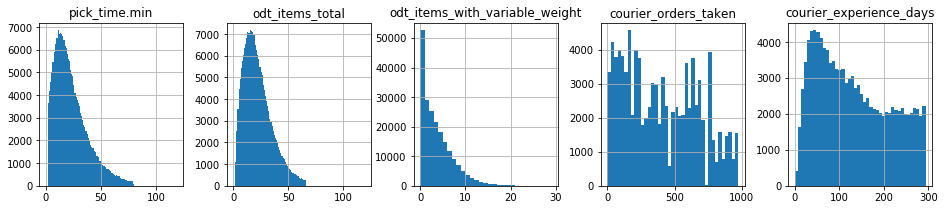

In [12]:
chart_distributions()

In [13]:
# augment delivery window date
orders = factory.run_plugin(orders, action=action, settings={
    "name": "analitico.plugin.AugmentDatesPlugin",
    "schema": {
        "columns": [
            { "name": "order_deliver_at_start" }
        ]
    }
})
#orders.drop(["order_deliver_at_start"], axis=1, inplace=True)
sample(orders)

,order_deliver_at_start,order_fulfillment_type,order_deliver_at_start.year,order_deliver_at_start.month,order_deliver_at_start.day,order_deliver_at_start.hour,order_deliver_at_start.minute,order_deliver_at_start.dayofweek,courier_id,odt_items_total,odt_items_with_variable_weight,store_name,store_area,store_province,store_ref_id,courier_created_days,pick_time.min,courier_area,courier_orders_taken,courier_experience_days
274141,2018-07-10 19:00:00,1,2018,7,10,19,0,1,81839.0,21,4,conad,RM2,RM,2915,476.860961,17.733333,RM1,4220,476
192109,2018-02-10 11:00:00,1,2018,2,10,11,0,5,101846.0,8,1,mercatò,TO2,TO,1295,153.979606,5.516667,TO2,1415,154
301848,2018-09-05 10:00:00,1,2018,9,5,10,0,2,67992.0,30,9,famila superstore,VR2,VR,2770,599.629398,35.950000,VR1,2644,599
271185,2018-07-05 15:00:00,1,2018,7,5,15,0,3,131547.0,18,2,famila superstore,VR2,VR,2770,78.210405,20.850000,VR2,829,78


In [14]:
# check a few orders
orders.tail(15)

,order_deliver_at_start,order_fulfillment_type,order_deliver_at_start.year,order_deliver_at_start.month,order_deliver_at_start.day,order_deliver_at_start.hour,order_deliver_at_start.minute,order_deliver_at_start.dayofweek,courier_id,odt_items_total,odt_items_with_variable_weight,store_name,store_area,store_province,store_ref_id,courier_created_days,pick_time.min,courier_area,courier_orders_taken,courier_experience_days
416790,2019-01-26 13:00:00,1,2019,1,26,13,0,5,139113.0,43,5,mercatò,TO5,TO,5207,199.222975,31.466667,TO5,64,199
416791,2019-01-26 13:00:00,1,2019,1,26,13,0,5,130417.0,28,9,carrefour market,RM16,RM,2823,294.160370,37.333333,RM16,76,294
416792,2019-01-26 13:00:00,1,2019,1,26,13,0,5,151001.0,14,1,auchan,RM7,RM,306,122.577720,24.216667,RM7,535,122
416793,2019-01-26 14:00:00,1,2019,1,26,14,0,5,90240.0,53,6,eurospin,RM10,RM,5055,604.140694,26.683333,RM10,1898,604
416795,2019-01-26 13:00:00,1,2019,1,26,13,0,5,149219.0,17,2,carrefour market,RM6,RM,2837,131.994884,12.833333,RM6,214,132
416796,2019-01-26 14:00:00,1,2019,1,26,14,0,5,108963.0,23,6,esselunga,MI6,MI,4455,459.132350,34.066667,MI6,1498,459
416797,2019-01-26 13:00:00,1,2019,1,26,13,0,5,159263.0,8,0,lidl,VR2,VR,5286,58.795868,11.000000,VR5,111,58
416798,2019-01-26 13:00:00,1,2019,1,26,13,0,5,131051.0,19,2,pam,GE3,GE,1885,288.968958,6.850000,GE3,276,288
416799,2019-01-26 13:00:00,3,2019,1,26,13,0,5,110835.0,13,4,esselunga,MI4,MI,5023,449.526204,45.766667,MI4,1404,449
416800,2019-01-26 13:00:00,1,2019,1,26,13,0,5,159517.0,3,0,ipercoop,MN1,MN,3386,57.688356,20.183333,MN1,60,57


In [15]:
# check data types
orders["courier_id"] = orders["courier_id"].astype("category")
orders["order_fulfillment_type"] = orders["order_fulfillment_type"].astype("category")
orders["store_name"] = orders["store_name"].astype("category")
orders["store_area"] = orders["store_area"].astype("category")
orders["store_province"] = orders["store_province"].astype("category")
orders["store_ref_id"] = orders["store_ref_id"].astype("category")
orders["courier_area"] = orders["courier_area"].astype("category")
orders["store_ref_id"] = orders["store_ref_id"].astype("category")
orders.dtypes

order_deliver_at_start              datetime64[ns]
order_fulfillment_type                    category
order_deliver_at_start.year               category
order_deliver_at_start.month              category
order_deliver_at_start.day                category
order_deliver_at_start.hour               category
order_deliver_at_start.minute             category
order_deliver_at_start.dayofweek          category
courier_id                                category
odt_items_total                              int64
odt_items_with_variable_weight               int64
store_name                                category
store_area                                category
store_province                            category
store_ref_id                              category
courier_created_days                       float64
pick_time.min                              float64
courier_area                              category
courier_orders_taken                         int64
courier_experience_days        

In [16]:
# train model with gradient boosting on decision trees
training = factory.run_plugin(orders, action="train", settings = {
    "name": "analitico.plugin.CatBoostRegressorPlugin",
    "data": {
        "chronological": False,
        "label": "pick_time.min"
    },
    "parameters": {
        "learning_rate": 1,
        "iterations": 100,
        "test_size": 0.2
    }
})

Column 'order_deliver_at_start' of type 'datetime' is incompatible and will be dropped


0:	learn: 11.8578020	test: 11.8343540	best: 11.8343540 (0)	total: 292ms	remaining: 28.9s
1:	learn: 11.2605145	test: 11.1993208	best: 11.1993208 (1)	total: 506ms	remaining: 24.8s
2:	learn: 10.9502073	test: 10.9183235	best: 10.9183235 (2)	total: 804ms	remaining: 26s
3:	learn: 10.7581656	test: 10.7187754	best: 10.7187754 (3)	total: 1.11s	remaining: 26.7s
4:	learn: 10.6345328	test: 10.5689366	best: 10.5689366 (4)	total: 1.42s	remaining: 27s
5:	learn: 10.5142948	test: 10.4862004	best: 10.4862004 (5)	total: 1.75s	remaining: 27.5s
6:	learn: 10.4210638	test: 10.4157460	best: 10.4157460 (6)	total: 1.99s	remaining: 26.4s
7:	learn: 10.3554200	test: 10.3442450	best: 10.3442450 (7)	total: 2.33s	remaining: 26.8s
8:	learn: 10.3120069	test: 10.3032751	best: 10.3032751 (8)	total: 2.63s	remaining: 26.6s
9:	learn: 10.2847344	test: 10.2852342	best: 10.2852342 (9)	total: 2.88s	remaining: 26s
10:	learn: 10.2579496	test: 10.2757795	best: 10.2757795 (10)	total: 3.18s	remaining: 25.7s
11:	learn: 10.2402911	tes

92:	learn: 9.5783769	test: 10.1149964	best: 10.0977302 (50)	total: 26.6s	remaining: 2s
93:	learn: 9.5703255	test: 10.1215547	best: 10.0977302 (50)	total: 26.9s	remaining: 1.72s
94:	learn: 9.5648775	test: 10.1213350	best: 10.0977302 (50)	total: 27.2s	remaining: 1.43s
95:	learn: 9.5569231	test: 10.1210290	best: 10.0977302 (50)	total: 27.5s	remaining: 1.15s
96:	learn: 9.5491947	test: 10.1206318	best: 10.0977302 (50)	total: 27.8s	remaining: 859ms
97:	learn: 9.5420681	test: 10.1212121	best: 10.0977302 (50)	total: 28.1s	remaining: 573ms
98:	learn: 9.5352847	test: 10.1233707	best: 10.0977302 (50)	total: 28.4s	remaining: 287ms
99:	learn: 9.5302615	test: 10.1269076	best: 10.0977302 (50)	total: 28.8s	remaining: 0us

bestTest = 10.09773024
bestIteration = 50

Shrink model to first 51 iterations.


In [17]:
training

OrderedDict([('type', 'analitico/training'),
             ('plugins',
              {'training': 'analitico.plugin.CatBoostRegressorPlugin',
               'prediction': 'analitico.plugin.CatBoostRegressorPlugin'}),
             ('data',
              {'label': 'pick_time.min',
               'chronological': False,
               'schema': {'columns': [{'name': 'order_fulfillment_type',
                  'type': 'category'},
                 {'name': 'order_deliver_at_start.year', 'type': 'category'},
                 {'name': 'order_deliver_at_start.month', 'type': 'category'},
                 {'name': 'order_deliver_at_start.day', 'type': 'category'},
                 {'name': 'order_deliver_at_start.hour', 'type': 'category'},
                 {'name': 'order_deliver_at_start.minute', 'type': 'category'},
                 {'name': 'order_deliver_at_start.dayofweek',
                  'type': 'category'},
                 {'name': 'courier_id', 'type': 'category'},
                

In [18]:
training["scores"]["features_importance"]

{'odt_items_total': 33.50419,
 'store_province': 12.27104,
 'courier_id': 12.25443,
 'courier_orders_taken': 11.79088,
 'store_name': 8.98764,
 'odt_items_with_variable_weight': 5.70531,
 'order_deliver_at_start.month': 3.06693,
 'order_fulfillment_type': 2.77034,
 'courier_experience_days': 2.31645,
 'courier_area': 2.03687,
 'store_area': 1.08833,
 'courier_created_days': 1.0552,
 'order_deliver_at_start.year': 0.97273,
 'store_ref_id': 0.74608,
 'order_deliver_at_start.hour': 0.57968,
 'order_deliver_at_start.day': 0.32606,
 'order_deliver_at_start.minute': 0.26957,
 'order_deliver_at_start.dayofweek': 0.25827}

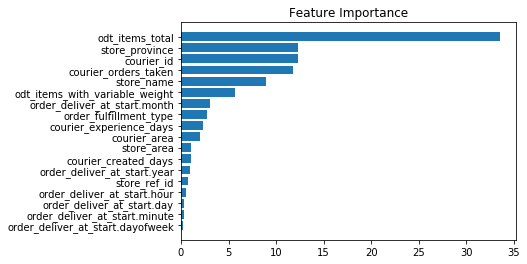

In [19]:
features_importance = training["scores"]["features_importance"]

features = list(features_importance.keys())
importances = list(features_importance.values())
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
num = len(features_importance)
plt.barh(range(0, num), importances)
#plt.bar([0,1,2], [3,30,90])

# Add feature names as x-axis labels
#plt.xticks(range(0, num), features, rotation=90)
plt.yticks(range(0, num), features)
plt.gca().invert_yaxis()
# Show plot
plt.show()

In [20]:
## Prediction

In [21]:
samples_filename = os.path.join(factory.get_artifacts_directory(), "training-samples.json")
data = pd.read_json(samples_filename, orient="records")
data

,courier_area,courier_created_days,courier_experience_days,courier_id,courier_orders_taken,odt_items_total,odt_items_with_variable_weight,order_deliver_at_start.day,order_deliver_at_start.dayofweek,order_deliver_at_start.hour,order_deliver_at_start.minute,order_deliver_at_start.month,order_deliver_at_start.year,order_fulfillment_type,pick_time.min,store_area,store_name,store_province,store_ref_id
0,RM6,162.039236,162,101498,2355,37,1,16,4,18,0,2,2018,1,17.400000,RM7,eurospin,RM,5031
1,PD1,409.680150,409,103208,2684,13,2,30,1,9,0,10,2018,1,33.716667,PD1,pam,PD,2430
2,RM10,450.844861,450,62384,1980,27,0,14,3,15,0,12,2017,1,12.950000,RM6,eurospin,RM,5055
3,RM12,903.956019,903,42150,2527,57,3,28,5,11,0,4,2018,1,14.216667,RM15,eurospin,RM,5053
4,TV1,738.606678,738,65072,1686,24,6,30,4,9,0,11,2018,1,21.266667,TV1,conad superstore,TV,5058
5,MI2,15.204907,15,148745,93,18,0,28,4,20,0,9,2018,1,54.716667,MI3,esselunga,MI,3218
6,PD1,482.038032,482,103350,1639,31,1,12,5,18,0,1,2019,1,13.766667,PD1,aliper,PD,224
7,TO5,483.310822,483,102636,1347,45,3,8,1,19,0,1,2019,1,26.450000,TO5,mercatò,TO,5207
8,BS1,352.694236,352,118149,633,15,5,12,5,12,0,1,2019,1,21.616667,BS1,famila superstore,BS,2201
9,RM12,723.652546,723,61472,2017,25,4,14,1,12,0,8,2018,1,11.466667,RM15,eurospin,RM,5053


In [28]:
if not isinstance(data, pd.DataFrame):
    data = pd.DataFrame.from_dict(data, orient="columns")

# when 
if not "order_deliver_at_start" in data.columns:
    data["order_deliver_at_start"] = pd.Timestamp.now()
    
data

,courier_area,courier_experience_days,courier_id,courier_orders_taken,odt_items_total,odt_items_with_variable_weight,order_deliver_at_start,order_fulfillment_type,pick_time.min,store_area,store_name,store_province,store_ref_id
0,MI13,306.284583,109135.0,249,12,0,2018-08-27 19:00:00,1,10.2,MI6,esselunga,MI,5042
1,MI4,316.780544,112147.0,3387,16,1,2018-09-28 20:00:00,1,38.9,MI4,ipercoop,MI,4494


In [29]:
# generate predictions
results = factory.run_plugin(data, action="predict", settings = [
    {
        "name": "s24.plugin.AugmentCouriersPlugin"
    },
    {
        "name": "analitico.plugin.AugmentDatesPlugin",
        "schema": {
            "columns": [
                { "name": "order_deliver_at_start" }
            ]
        }
    },
    {
        "name": "analitico.plugin.CatBoostRegressorPlugin",
        "data": {
            "chronological": False,
            "label": "pick_time.min"
        },
        "parameters": {
            "learning_rate": 1,
            "iterations": 100,
            "test_size": 0.2
        }
    }
])

/home/gionata/github/analitico/venv/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
results

OrderedDict([('type', 'analitico/prediction'),
             ('endpoint_id', None),
             ('model_id', None),
             ('job_id', None),
             ('records', None),
             ('processed', None),
             ('predictions',
              [22.312,
               10.484,
               15.597,
               25.825,
               28.189,
               37.893,
               19.121,
               40.302,
               18.239,
               16.592,
               20.182,
               12.964,
               10.189,
               22.398,
               19.658,
               9.791,
               35.525,
               -1.421,
               32.517,
               23.008,
               16.597,
               19.101,
               13.411,
               20.284,
               26.756,
               9.0,
               14.015,
               17.367,
               11.287,
               33.309,
               12.045,
               21.268,
               23.287,
   

In [25]:
data

,courier_created_days,courier_id,odt_items_total,odt_items_with_variable_weight,order_deliver_at_start.day,order_deliver_at_start.dayofweek,order_deliver_at_start.hour,order_deliver_at_start.minute,order_deliver_at_start.month,order_deliver_at_start.year,order_fulfillment_type,pick_time.min,store_area,store_name,store_province,store_ref_id,order_paid_at
0,162.039236,101498,37,1,16,4,18,0,2,2018,1,17.400000,RM7,eurospin,RM,5031,2019-03-23 19:16:13.643041
1,409.680150,103208,13,2,30,1,9,0,10,2018,1,33.716667,PD1,pam,PD,2430,2019-03-23 19:16:13.643041
2,450.844861,62384,27,0,14,3,15,0,12,2017,1,12.950000,RM6,eurospin,RM,5055,2019-03-23 19:16:13.643041
3,903.956019,42150,57,3,28,5,11,0,4,2018,1,14.216667,RM15,eurospin,RM,5053,2019-03-23 19:16:13.643041
4,738.606678,65072,24,6,30,4,9,0,11,2018,1,21.266667,TV1,conad superstore,TV,5058,2019-03-23 19:16:13.643041
5,15.204907,148745,18,0,28,4,20,0,9,2018,1,54.716667,MI3,esselunga,MI,3218,2019-03-23 19:16:13.643041
6,482.038032,103350,31,1,12,5,18,0,1,2019,1,13.766667,PD1,aliper,PD,224,2019-03-23 19:16:13.643041
7,483.310822,102636,45,3,8,1,19,0,1,2019,1,26.450000,TO5,mercatò,TO,5207,2019-03-23 19:16:13.643041
8,352.694236,118149,15,5,12,5,12,0,1,2019,1,21.616667,BS1,famila superstore,BS,2201,2019-03-23 19:16:13.643041
9,723.652546,61472,25,4,14,1,12,0,8,2018,1,11.466667,RM15,eurospin,RM,5053,2019-03-23 19:16:13.643041


In [26]:
# print test results if running entire notebook linearly
from sklearn.metrics import *

if y_label in data.columns and not data[y_label].isnull().values.any():
    y_true = data[y_label]
    y_pred = results["predictions"]

    print("mean_squared_error: %.3f" % mean_squared_error(y_true, y_pred))
    print("mean_absolute_error: %.3f" % mean_absolute_error(y_true, y_pred))
    print("median_absolute_error: %.3f" % median_absolute_error(y_true, y_pred))
    print("explained_variance_score: %.3f\n" % explained_variance_score(y_true, y_pred))

    print("row  items   y_true   y_pred  true/pr")
    for i in range(len(data.index)):
        items = data.loc[i]["odt_items_total"]
        print("%3d %6d %8.2f %8.2f %8.2f" % (i, items, y_true[i], y_pred[i], 1-(y_true[i] / y_pred[i])))

mean_squared_error: 105.412
mean_absolute_error: 7.458
median_absolute_error: 5.499
explained_variance_score: 0.546

row  items   y_true   y_pred  true/pr
  0     37    17.40    22.31     0.22
  1     13    33.72    10.48    -2.22
  2     27    12.95    15.60     0.17
  3     57    14.22    25.82     0.45
  4     24    21.27    28.19     0.25
  5     18    54.72    37.89    -0.44
  6     31    13.77    19.12     0.28
  7     45    26.45    40.30     0.34
  8     15    21.62    18.24    -0.19
  9     25    11.47    16.59     0.31
 10     14    29.18    20.18    -0.45
 11     12     9.08    12.96     0.30
 12     25    19.38    10.19    -0.90
 13     19    13.42    22.40     0.40
 14     11    12.00    19.66     0.39
 15      7     5.02     9.79     0.49
 16     35    40.47    35.52    -0.14
 17     26     3.58    -1.42     3.52
 18     33    38.68    32.52    -0.19
 19     18    21.50    23.01     0.07
 20     33    17.67    16.60    -0.06
 21     18    26.77    19.10    -0.40
 22     1